In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import nltk
from nltk.corpus import stopwords

import re
import string

import keras
from keras.layers import LSTM,Embedding,Dense,Bidirectional,GlobalMaxPool2D,BatchNormalization,Dropout,TimeDistributed,GlobalMaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from tensorflow.keras import layers
from keras.layers import SpatialDropout1D,GRU
from keras.layers import Conv1D, Flatten, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt




In [3]:
#download data
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [4]:
#reading the data 
data_train = pd.read_csv('/content/train.csv')


In [5]:
#explore data
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data_train.shape

(7613, 5)

In [7]:
# Count labels to see if the datset is imbalanced 
data_train['target'].value_counts()

#relatively balanced data

0    4342
1    3271
Name: target, dtype: int64

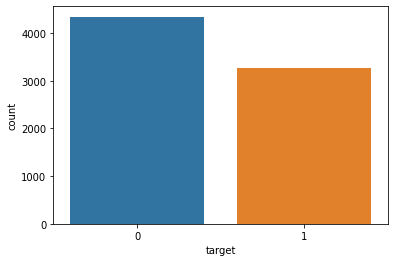

In [8]:
# Plot target values
import seaborn as sns
sns.countplot(x = 'target', data = data_train)

In [9]:
# 1. Preprocessing 

#drop unnecessary cols 

data_train_new = data_train.drop(['keyword', 'location'], axis=1)

data_train_new.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# function to clean text 

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text



In [11]:
# apply the cleaning function to the dataset
data_train_new.text = data_train_new.text.apply(lambda x: clean_text(x))



In [12]:
#function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [13]:
# apply the function to the dataset

data_train_new['text']= data_train_new['text'].apply(lambda x: remove_emoji(x))


In [14]:
#remove stop words 
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)


data_train_new["text"] = data_train_new["text"].map(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
data_train_new.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


In [16]:
#make a copy
tweets= data_train_new['text'].copy()

In [17]:
# Tokenize data 
t = Tokenizer()
t.fit_on_texts(tweets)
vocab_size_train = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(tweets)
# pad documents to a max length
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

tweets= padded_docs


In [18]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-31 15:38:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-31 15:38:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-31 15:38:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
#!unzip glove*.zip

In [21]:
#GloVe word embeddings

embeddings_index = {}
with open('/content/glove.6B.200d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [22]:
#create a embedding weight matrix for words in the dataset
embedding_matrix = np.zeros((vocab_size_train, 
                             200))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


In [23]:
#Creating an Embedding layer
e = Embedding(vocab_size_train, 200, weights=[embedding_matrix], 
              input_length=100, trainable=False)



In [24]:
#split data into train and validation 

label = data_train_new['target']
X_train,X_val,y_train,y_val= train_test_split(tweets,label, test_size=0.3 )

In [138]:
# check data 
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(6090, 100)
(6090,)
(1523, 100)
(1523,)


In [9]:
#!pip install -U keras -tuner
!#pip install keras-tuner --upgrade

In [125]:
# 2. Modeling

#Build a model for tuning hyperparameters 
#num of neurons
#learning rate 

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model



In [126]:
#define tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='dir')

In [127]:
#summary of searching space
tuner.search_space_summary()


Search space summary
Default search space size: 2
units_16700 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [128]:
#fit tuner
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_val, y_val))


Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.5624863306681315

Best val_accuracy So Far: 0.5732107758522034
Total elapsed time: 00h 01m 04s
INFO:tensorflow:Oracle triggered exit


In [129]:
#results summary
tuner.results_summary()

Results summary
Results in dir/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_16700: 320
learning_rate: 0.001
Score: 0.5732107758522034
Trial summary
Hyperparameters:
units_16700: 128
learning_rate: 0.001
Score: 0.5624863306681315
Trial summary
Hyperparameters:
units_16700: 128
learning_rate: 0.0001
Score: 0.5259356300036112
Trial summary
Hyperparameters:
units_16700: 64
learning_rate: 0.0001
Score: 0.523965855439504
Trial summary
Hyperparameters:
units_16700: 96
learning_rate: 0.0001
Score: 0.5202451149622599


In [25]:
# a. Baseline model 

model_1=Sequential()
model_1.add(e)
model_1.add(Dense(1, activation = "sigmoid"))
model_1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])



In [162]:
history_1= model_1.fit(X_train,y_train,validation_data=(X_val,y_val),
                   epochs=20,batch_size=64,verbose=2)

Epoch 1/20
96/96 - 1s - loss: 0.6895 - accuracy: 0.5736 - val_loss: 0.6858 - val_accuracy: 0.5809 - 852ms/epoch - 9ms/step
Epoch 2/20
96/96 - 0s - loss: 0.6839 - accuracy: 0.5775 - val_loss: 0.6819 - val_accuracy: 0.5828 - 304ms/epoch - 3ms/step
Epoch 3/20
96/96 - 0s - loss: 0.6812 - accuracy: 0.5783 - val_loss: 0.6797 - val_accuracy: 0.5834 - 297ms/epoch - 3ms/step
Epoch 4/20
96/96 - 0s - loss: 0.6796 - accuracy: 0.5787 - val_loss: 0.6783 - val_accuracy: 0.5838 - 303ms/epoch - 3ms/step
Epoch 5/20
96/96 - 0s - loss: 0.6787 - accuracy: 0.5788 - val_loss: 0.6775 - val_accuracy: 0.5840 - 317ms/epoch - 3ms/step
Epoch 6/20
96/96 - 0s - loss: 0.6782 - accuracy: 0.5788 - val_loss: 0.6770 - val_accuracy: 0.5841 - 307ms/epoch - 3ms/step
Epoch 7/20
96/96 - 0s - loss: 0.6779 - accuracy: 0.5790 - val_loss: 0.6768 - val_accuracy: 0.5841 - 323ms/epoch - 3ms/step
Epoch 8/20
96/96 - 0s - loss: 0.6777 - accuracy: 0.5789 - val_loss: 0.6765 - val_accuracy: 0.5841 - 312ms/epoch - 3ms/step
Epoch 9/20
96/96

In [160]:
# f1 score for baseline model
y_pred = model_1.predict(X_val)
y_pred_bool = np.argmax(y_pred, axis=1)

# Print f1, precision, and recall scores
print(f1_score(y_val, y_pred_bool , average="macro"))

0.022229108399016866


In [153]:
#Average accuraccy for baseline model
mean_acc_baseline = np.mean(history_1.history['accuracy'])
print(mean_acc_baseline)

0.43070608377456665


In [130]:
#define optimizer and learning rate
opt = Adam(learning_rate=0.001)

In [131]:
# 2.Modeling 

# b.LSTM 

model=Sequential()
model.add(e)
model.add(LSTM(100, dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          3340200   
                                                                 
 lstm (LSTM)                 (None, 320)               666880    
                                                                 
 batch_normalization (BatchN  (None, 320)              1280      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1)                 321       
                                                                 
Total params: 4,008,681
Trainable params: 667,841
Non-trainable params: 3,340,840
_________________________________________________________________


In [152]:
history= model.fit(X_train,y_train,validation_data=(X_val,y_val),
                   epochs=20,batch_size=64,verbose=2)


Epoch 1/20
96/96 - 35s - loss: 0.6863 - accuracy: 0.5645 - val_loss: 0.6805 - val_accuracy: 0.5811 - 35s/epoch - 364ms/step
Epoch 2/20
96/96 - 31s - loss: 0.5711 - accuracy: 0.7190 - val_loss: 0.5366 - val_accuracy: 0.7984 - 31s/epoch - 326ms/step
Epoch 3/20
96/96 - 32s - loss: 0.4752 - accuracy: 0.7938 - val_loss: 0.6248 - val_accuracy: 0.5883 - 32s/epoch - 331ms/step
Epoch 4/20
96/96 - 31s - loss: 0.4547 - accuracy: 0.8036 - val_loss: 0.4569 - val_accuracy: 0.7951 - 31s/epoch - 324ms/step
Epoch 5/20
96/96 - 32s - loss: 0.4424 - accuracy: 0.8089 - val_loss: 0.4339 - val_accuracy: 0.8083 - 32s/epoch - 328ms/step
Epoch 6/20
96/96 - 31s - loss: 0.4407 - accuracy: 0.8033 - val_loss: 0.6156 - val_accuracy: 0.8030 - 31s/epoch - 327ms/step
Epoch 7/20
96/96 - 31s - loss: 0.4267 - accuracy: 0.8177 - val_loss: 0.4253 - val_accuracy: 0.8096 - 31s/epoch - 325ms/step
Epoch 8/20
96/96 - 31s - loss: 0.4160 - accuracy: 0.8172 - val_loss: 0.7712 - val_accuracy: 0.8063 - 31s/epoch - 325ms/step
Epoch 9/

(0.0, 1.0)

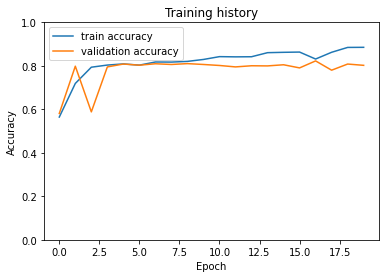

In [157]:
#plot train and validation accuracy 
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])


In [168]:
# f1 score for LSTM
y_pred = model.predict(X_val)
y_pred_bool = np.argmax(y_pred, axis=1)

print(f1_score(y_val, y_pred_bool, average="macro"))

0.36488740617180987


In [160]:
#avereage accuracy for LSTM
mean_acc_LSTM = np.mean(history.history['accuracy'])
print(mean_acc_LSTM)

0.8176765143871307


In [166]:
 # c. Bidirectional LSTM    

model_2=Sequential()
model_2.add(e)
model_2.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation = "sigmoid"))
model_2.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          3340200   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              240800    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,582,001
Trainable params: 241,401
Non-trainable params: 3,340,600
_________________________________________________________________


In [169]:
history_2= model_2.fit(X_train,y_train,validation_data=(X_val,y_val),
                   epochs=20,batch_size=64,verbose=2)

Epoch 1/20
96/96 - 68s - loss: 0.4971 - accuracy: 0.7644 - val_loss: 0.5236 - val_accuracy: 0.7886 - 68s/epoch - 705ms/step
Epoch 2/20
96/96 - 64s - loss: 0.4398 - accuracy: 0.7997 - val_loss: 0.4963 - val_accuracy: 0.8050 - 64s/epoch - 664ms/step
Epoch 3/20
96/96 - 63s - loss: 0.4150 - accuracy: 0.8146 - val_loss: 0.4476 - val_accuracy: 0.8116 - 63s/epoch - 653ms/step
Epoch 4/20
96/96 - 63s - loss: 0.3992 - accuracy: 0.8297 - val_loss: 0.4365 - val_accuracy: 0.8076 - 63s/epoch - 652ms/step
Epoch 5/20
96/96 - 63s - loss: 0.3805 - accuracy: 0.8320 - val_loss: 0.4217 - val_accuracy: 0.8109 - 63s/epoch - 653ms/step
Epoch 6/20
96/96 - 63s - loss: 0.3608 - accuracy: 0.8453 - val_loss: 0.4316 - val_accuracy: 0.8050 - 63s/epoch - 654ms/step
Epoch 7/20
96/96 - 63s - loss: 0.3432 - accuracy: 0.8544 - val_loss: 0.4392 - val_accuracy: 0.8135 - 63s/epoch - 654ms/step
Epoch 8/20
96/96 - 62s - loss: 0.3332 - accuracy: 0.8527 - val_loss: 0.4542 - val_accuracy: 0.8109 - 62s/epoch - 651ms/step
Epoch 9/

(0.0, 1.0)

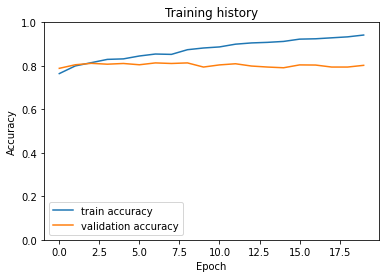

In [170]:
#train and val acc for BiLSTM
plt.plot(history_2.history['accuracy'], label='train accuracy')
plt.plot(history_2.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [169]:
# f1 score for BiLSTM
y_pred = model_2.predict(X_val)
y_pred_bool = np.argmax(y_pred, axis=1)

print(f1_score(y_val, y_pred_bool, average="macro" ))

0.41927311937010325


In [173]:
# average acc for BiLSTM
mean_acc_BiLSTM = np.mean(history_2.history['accuracy'])
print(mean_acc_BiLSTM)

0.8756403923034668


In [202]:
#d.CNN

model_3 = Sequential()
model_3.add(e)
model_3.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Flatten())
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 200)          3340200   
                                                                 
 conv1d_8 (Conv1D)           (None, 97, 32)            25632     
                                                                 
 dropout_8 (Dropout)         (None, 97, 32)            0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 dense_48 (Dense)            (None, 10)                10250     
                                                     

In [203]:
history_3= model_3.fit(X_train,y_train,validation_data=(X_val,y_val),
                   epochs=20,batch_size=64,verbose=2)

Epoch 1/20
96/96 - 1s - loss: 0.4936 - accuracy: 0.7704 - val_loss: 0.4338 - val_accuracy: 0.8116 - 964ms/epoch - 10ms/step
Epoch 2/20
96/96 - 0s - loss: 0.3925 - accuracy: 0.8322 - val_loss: 0.4393 - val_accuracy: 0.8109 - 318ms/epoch - 3ms/step
Epoch 3/20
96/96 - 0s - loss: 0.3348 - accuracy: 0.8580 - val_loss: 0.4522 - val_accuracy: 0.7951 - 315ms/epoch - 3ms/step
Epoch 4/20
96/96 - 0s - loss: 0.2791 - accuracy: 0.8877 - val_loss: 0.4878 - val_accuracy: 0.7991 - 335ms/epoch - 3ms/step
Epoch 5/20
96/96 - 0s - loss: 0.2328 - accuracy: 0.9080 - val_loss: 0.5186 - val_accuracy: 0.7853 - 314ms/epoch - 3ms/step
Epoch 6/20
96/96 - 0s - loss: 0.1915 - accuracy: 0.9291 - val_loss: 0.5670 - val_accuracy: 0.7853 - 344ms/epoch - 4ms/step
Epoch 7/20
96/96 - 0s - loss: 0.1780 - accuracy: 0.9345 - val_loss: 0.5859 - val_accuracy: 0.7912 - 328ms/epoch - 3ms/step
Epoch 8/20
96/96 - 0s - loss: 0.1562 - accuracy: 0.9427 - val_loss: 0.6410 - val_accuracy: 0.7873 - 305ms/epoch - 3ms/step
Epoch 9/20
96/9

(0.0, 1.0)

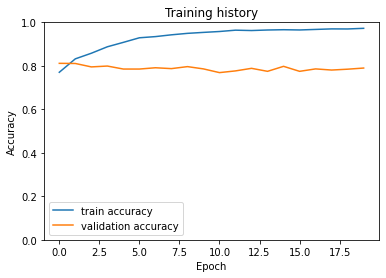

In [204]:
#plot tarin and val acc
plt.plot(history_3.history['accuracy'], label='train accuracy')
plt.plot(history_3.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [215]:
#f1 score for CNN
y_pred = model_3.predict(X_val)
y_pred_bool = np.argmax(y_pred, axis=1)


print(f1_score(y_val, y_pred_bool, average="micro" ))

0.5810899540380827


In [207]:
#Average acc of CNN
mean_acc_CNN= np.mean(history_3.history['accuracy'])
print(mean_acc_CNN)

0.9312972038984298
